In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pytensor.tensor as pt
from pymc_extras.prior import Censored, Prior
from pytensor.graph import rewrite_graph

from pymc_marketing.mmm import GeometricAdstock, MichaelisMentenSaturation
from pymc_marketing.mmm.multidimensional import MMM

SEED = 142
n_observations = 1050

warnings.filterwarnings("ignore")

# Set the style
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["axes.labelsize"] = 6
plt.rcParams["xtick.labelsize"] = 6
plt.rcParams["ytick.labelsize"] = 6

%config InlineBackend.figure_format = "retina"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/carlostrujillo/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/multidimensional.py:215: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)


In [2]:
min_date = pd.to_datetime("2022-01-01")
max_date = min_date + pd.Timedelta(days=n_observations)

date_range = pd.date_range(start=min_date, end=max_date, freq="D")

df = pd.DataFrame(data={"date_week": date_range}).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

In [3]:
impressions_x1 = pt.vector("impressions_x1")
beta_x1_x2 = pt.scalar("beta_x1_x2")
beta_x1_x3 = pt.scalar("beta_x1_x3")
impressions_x2 = pt.vector("impressions_x2") + (impressions_x1 * beta_x1_x2)
impressions_x3 = pt.vector("impressions_x3") + (impressions_x1 * beta_x1_x3)
beta_x2_x4 = pt.scalar("beta_x2_x4")
beta_x3_x4 = pt.scalar("beta_x3_x4")
impressions_x4 = (
    pt.vector("impressions_x4")
    + (impressions_x2 * beta_x2_x4)
    + (impressions_x3 * beta_x3_x4)
)

In [4]:
impressions_x4.dprint()

Add [id A]
 ├─ Add [id B]
 │  ├─ impressions_x4 [id C]
 │  └─ Mul [id D]
 │     ├─ Add [id E]
 │     │  ├─ impressions_x2 [id F]
 │     │  └─ Mul [id G]
 │     │     ├─ impressions_x1 [id H]
 │     │     └─ ExpandDims{axis=0} [id I]
 │     │        └─ beta_x1_x2 [id J]
 │     └─ ExpandDims{axis=0} [id K]
 │        └─ beta_x2_x4 [id L]
 └─ Mul [id M]
    ├─ Add [id N]
    │  ├─ impressions_x3 [id O]
    │  └─ Mul [id P]
    │     ├─ impressions_x1 [id H]
    │     └─ ExpandDims{axis=0} [id Q]
    │        └─ beta_x1_x3 [id R]
    └─ ExpandDims{axis=0} [id S]
       └─ beta_x3_x4 [id T]


In [5]:
# def random_walk(mu, sigma, steps, lower=None, upper=None):
#     """
#     Generate a bounded random walk with specified mean and standard deviation.

#     Parameters:
#     -----------
#     mu : float
#         Target mean of the random walk
#     sigma : float
#         Target standard deviation of the random walk
#     steps : int
#         Number of steps in the random walk
#     lower : float, optional
#         Lower bound for the random walk values
#     upper : float, optional
#         Upper bound for the random walk values

#     Returns:
#     --------
#     np.ndarray
#         Random walk array with specified mean, std, and bounds
#     """
#     # Start from the target mean
#     walk = np.zeros(steps)
#     walk[0] = mu

#     # Generate the walk step by step with bounds checking
#     for i in range(1, steps):
#         # Generate a random increment
#         increment = np.random.normal(0, sigma * 0.1)  # Scale increment size

#         # Propose next value
#         next_val = walk[i-1] + increment

#         # Apply bounds if specified
#         if lower is not None and next_val < lower:
#             # Reflect off lower bound
#             next_val = lower + (lower - next_val)
#         if upper is not None and next_val > upper:
#             # Reflect off upper bound
#             next_val = upper - (next_val - upper)

#         # Final bounds check (hard clipping as backup)
#         if lower is not None:
#             next_val = max(next_val, lower)
#         if upper is not None:
#             next_val = min(next_val, upper)

#         walk[i] = next_val

#     # Adjust to match target mean and std while respecting bounds
#     current_mean = np.mean(walk)
#     current_std = np.std(walk)

#     if current_std > 0:
#         # Center around zero, scale to target std, then shift to target mean
#         walk_centered = (walk - current_mean) / current_std * sigma + mu

#         # Apply bounds again after scaling
#         if lower is not None:
#             walk_centered = np.maximum(walk_centered, lower)
#         if upper is not None:
#             walk_centered = np.minimum(walk_centered, upper)

#         walk = walk_centered

#     return walk

In [6]:
def random_walk(mu, sigma, steps, lower=None, upper=None, seed=None):
    """
    Generate a bounded random walk with specified mean and standard deviation.

    Parameters
    ----------
    mu : float
        Target mean of the random walk
    sigma : float
        Target standard deviation of the random walk
    steps : int
        Number of steps in the random walk
    lower : float, optional
        Lower bound for the random walk values
    upper : float, optional
        Upper bound for the random walk values
    seed : int, optional
        Random seed for reproducibility

    Returns
    -------
    np.ndarray
        Random walk array with specified mean, std, and bounds
    """
    # if seed none then set 123
    if seed is None:
        seed = 123
    # Create a random number generator with the given seed
    rng = np.random.RandomState(seed)

    # Start from the target mean
    walk = np.zeros(steps)
    walk[0] = mu

    # Generate the walk step by step with bounds checking
    for i in range(1, steps):
        # Generate a random increment using the seeded RNG
        increment = rng.normal(0, sigma * 0.1)  # Scale increment size

        # Propose next value
        next_val = walk[i - 1] + increment

        # Apply bounds if specified
        if lower is not None and next_val < lower:
            # Reflect off lower bound
            next_val = lower + (lower - next_val)
        if upper is not None and next_val > upper:
            # Reflect off upper bound
            next_val = upper - (next_val - upper)

        # Final bounds check (hard clipping as backup)
        if lower is not None:
            next_val = max(next_val, lower)
        if upper is not None:
            next_val = min(next_val, upper)

        walk[i] = next_val

    # Adjust to match target mean and std while respecting bounds
    current_mean = np.mean(walk)
    current_std = np.std(walk)

    if current_std > 0:
        # Center around zero, scale to target std, then shift to target mean
        walk_centered = (walk - current_mean) / current_std * sigma + mu

        # Apply bounds again after scaling
        if lower is not None:
            walk_centered = np.maximum(walk_centered, lower)
        if upper is not None:
            walk_centered = np.minimum(walk_centered, upper)

        walk = walk_centered

    return walk

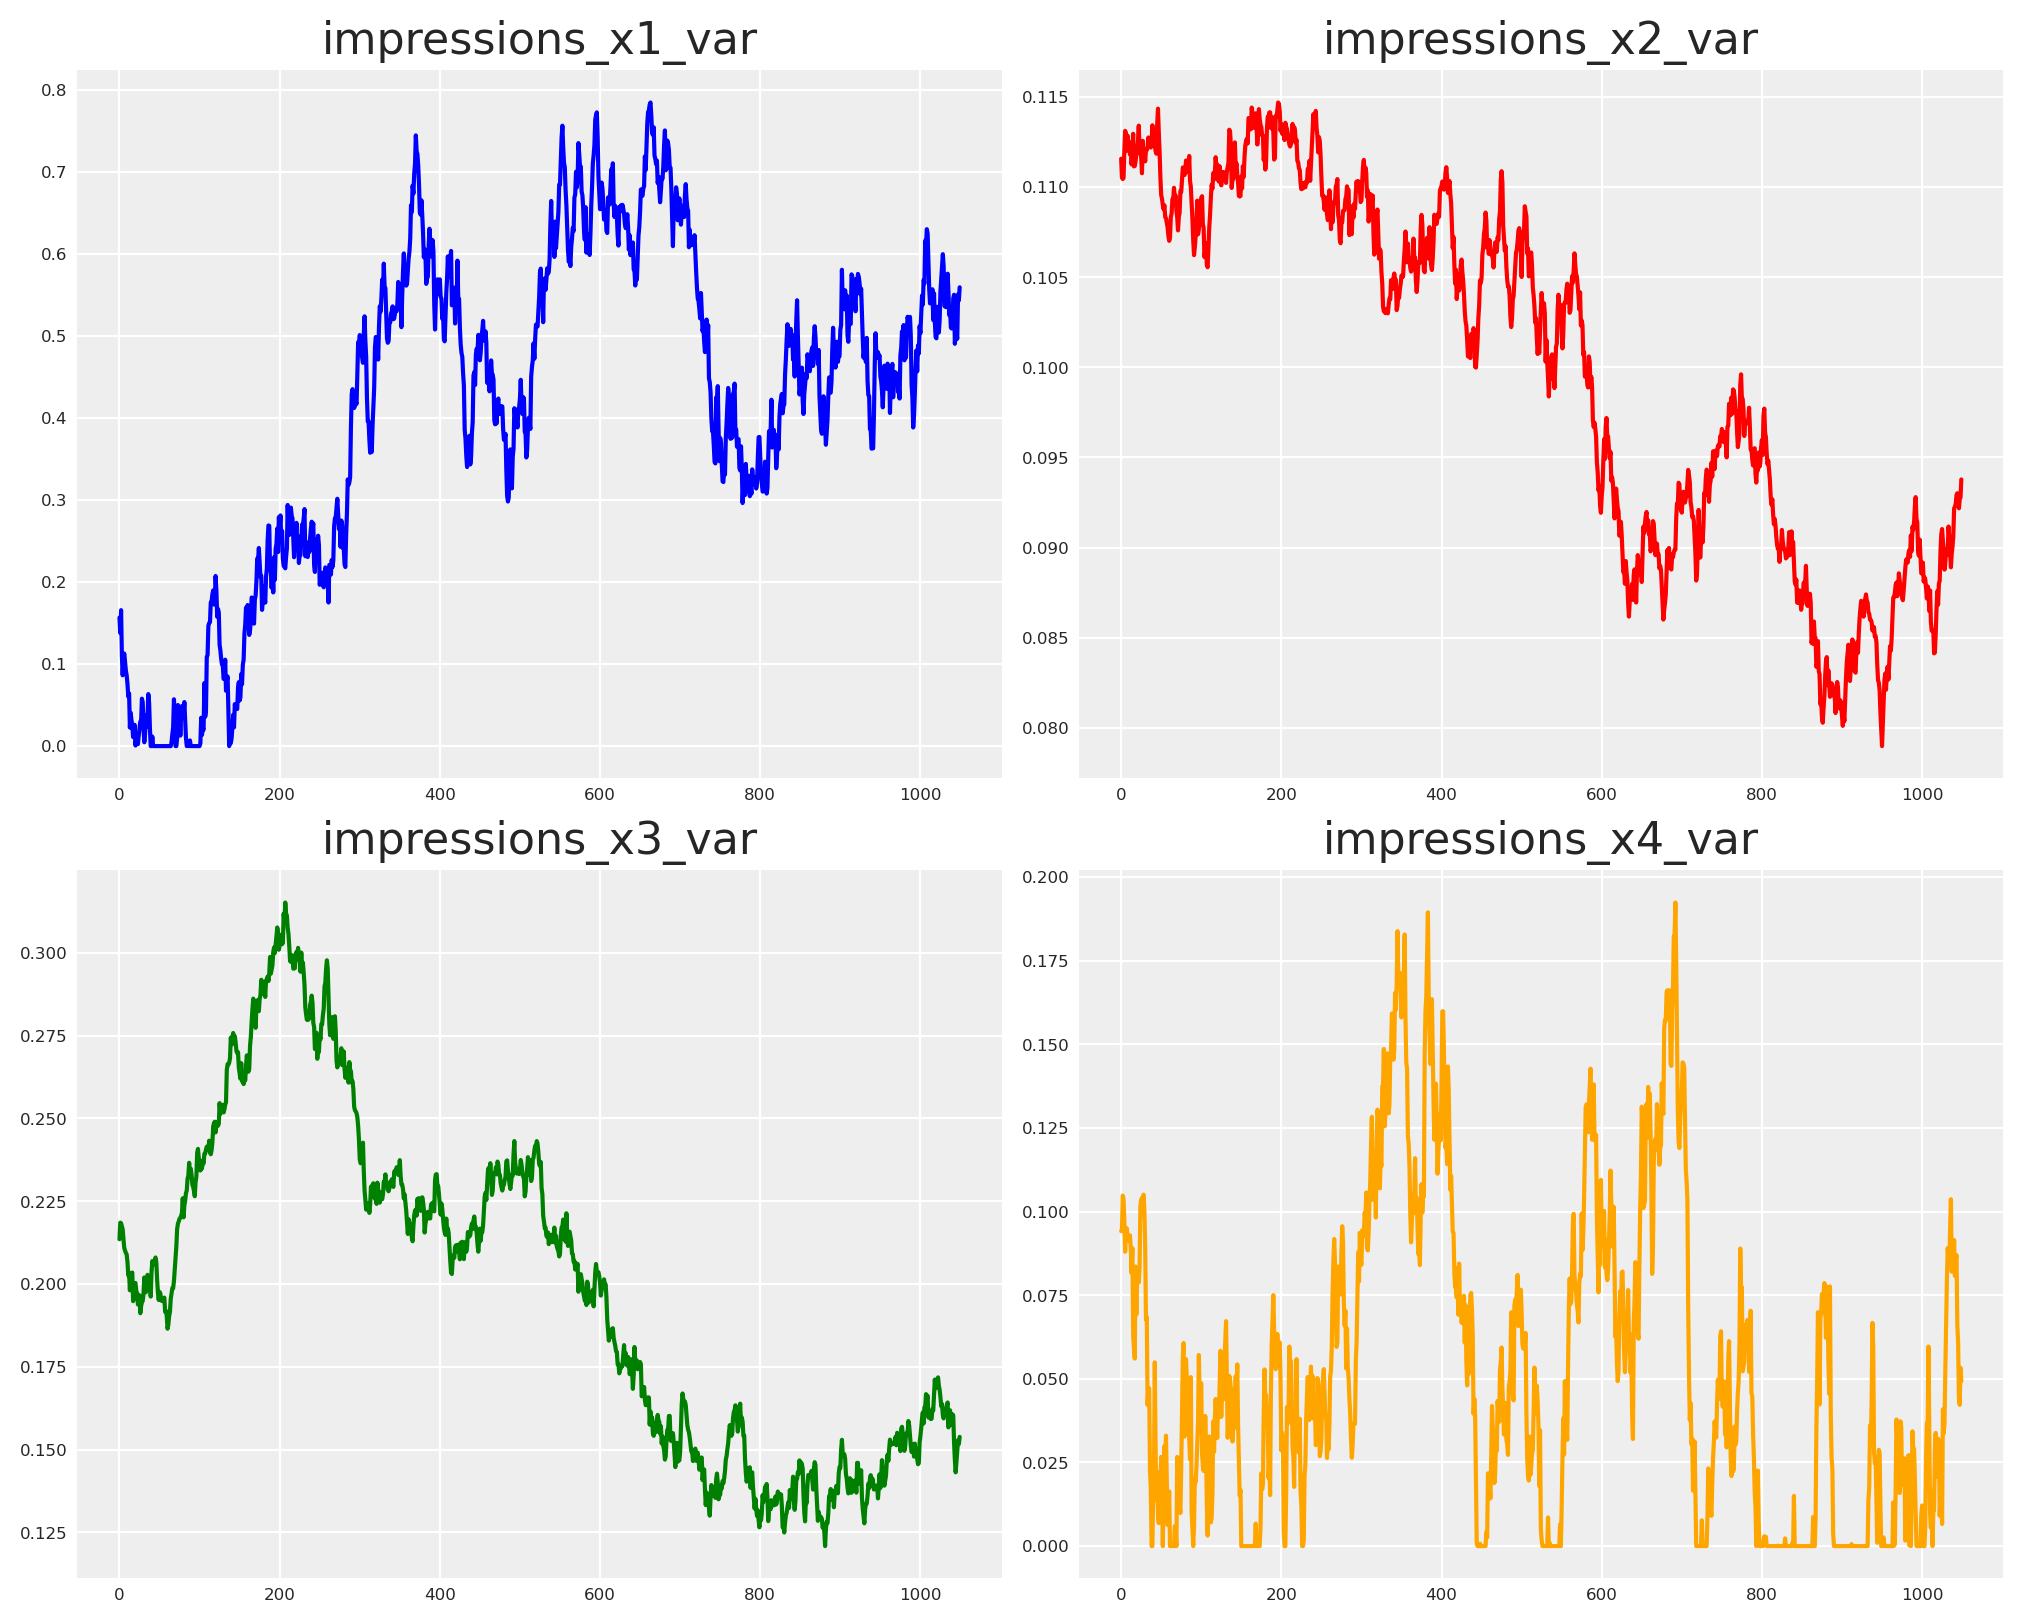

In [7]:
impressions_x1_var = random_walk(
    mu=0.41, sigma=0.21, steps=n_observations, lower=0, upper=1, seed=SEED + 1
)
impressions_x2_var = random_walk(
    mu=0.1, sigma=0.01, steps=n_observations, lower=0, upper=1, seed=SEED + 2
)
impressions_x3_var = random_walk(
    mu=0.2, sigma=0.05, steps=n_observations, lower=0, upper=1, seed=SEED - 3
)
impressions_x4_var = random_walk(
    mu=0.05, sigma=0.05, steps=n_observations, lower=0, upper=1, seed=SEED - 1
)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot(impressions_x1_var, color="blue")
axs[0, 0].set_title("impressions_x1_var")
axs[0, 1].plot(impressions_x2_var, color="red")
axs[0, 1].set_title("impressions_x2_var")
axs[1, 0].plot(impressions_x3_var, color="green")
axs[1, 0].set_title("impressions_x3_var")
axs[1, 1].plot(impressions_x4_var, color="orange")
axs[1, 1].set_title("impressions_x4_var")
plt.show()

In [8]:
beta_x1_x2_var = 0.02
beta_x1_x3_var = 0.03
beta_x2_x4_var = 0.04
beta_x3_x4_var = 0.05

impressions_x1_eval = impressions_x1.eval(
    {
        "impressions_x1": impressions_x1_var,
    }
)

impressions_x2_eval = impressions_x2.eval(
    {
        "impressions_x1": impressions_x1_var,
        "impressions_x2": impressions_x2_var,
        "beta_x1_x2": beta_x1_x2_var,
    }
)

impressions_x3_eval = impressions_x3.eval(
    {
        "impressions_x1": impressions_x1_var,
        "impressions_x3": impressions_x3_var,
        "beta_x1_x3": beta_x1_x3_var,
    }
)

impressions_x4_eval = impressions_x4.eval(
    {
        "impressions_x1": impressions_x1_var,
        "impressions_x2": impressions_x2_var,
        "impressions_x3": impressions_x3_var,
        "impressions_x4": impressions_x4_var,
        "beta_x1_x2": beta_x1_x2_var,
        "beta_x1_x3": beta_x1_x3_var,
        "beta_x2_x4": beta_x2_x4_var,
        "beta_x3_x4": beta_x3_x4_var,
    }
)

Text(0.5, 1.0, 'impressions_x4_eval')

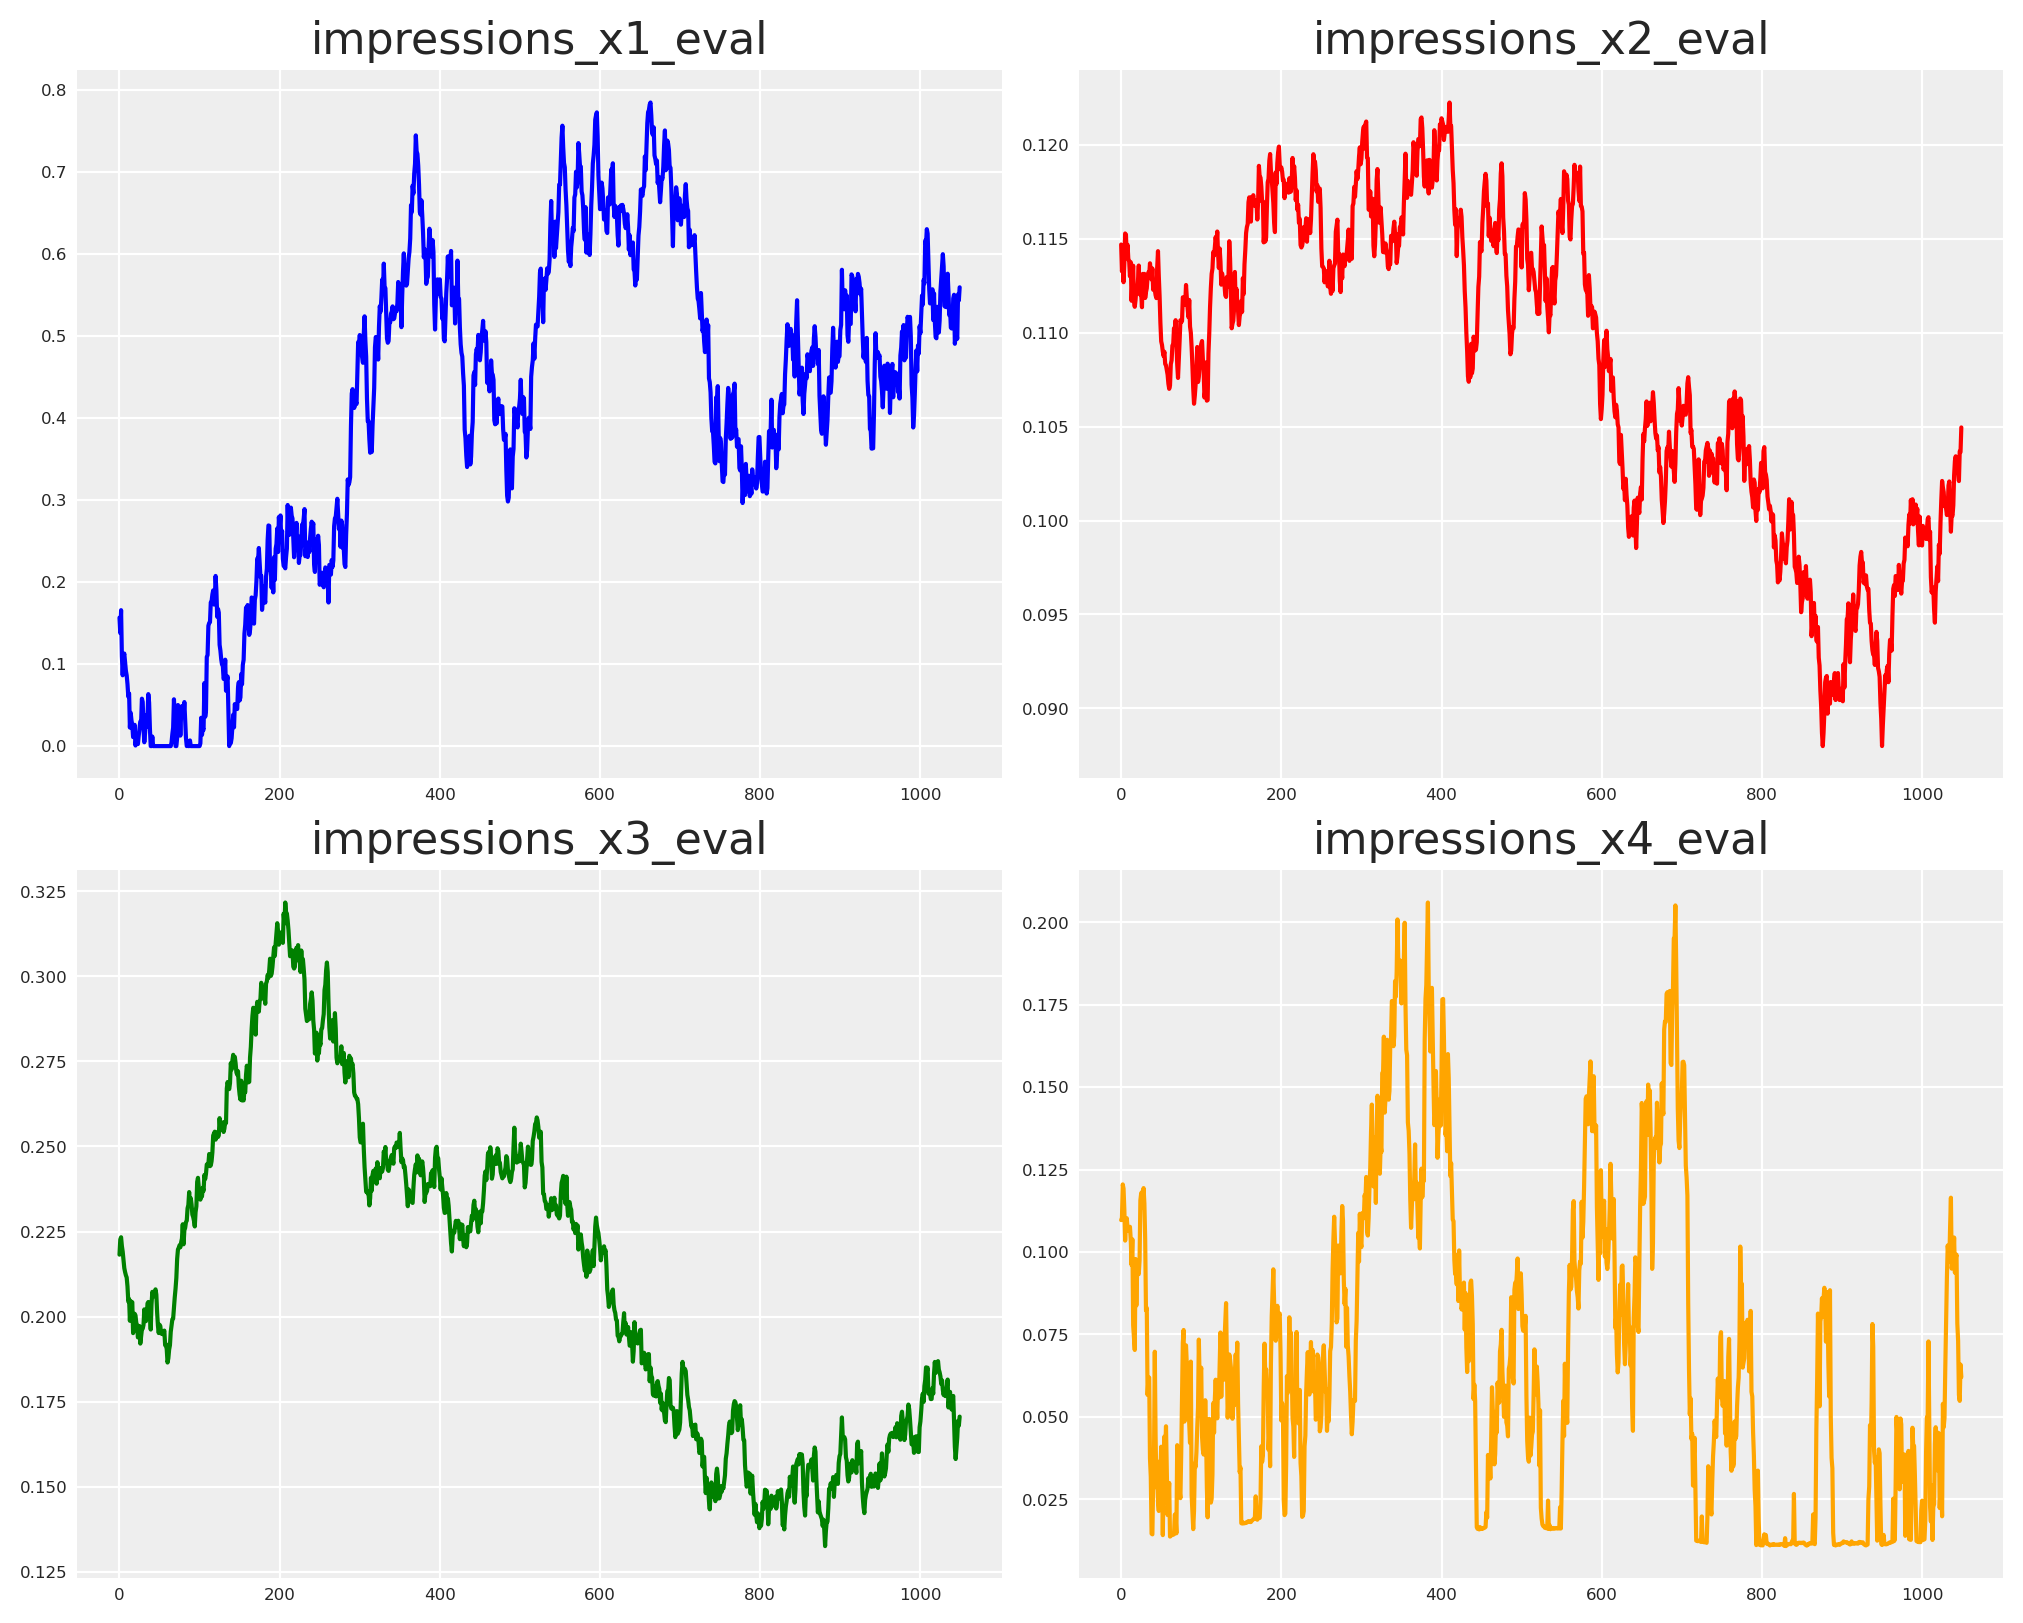

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot(impressions_x1_eval, color="blue")
axs[0, 0].set_title("impressions_x1_eval")
axs[0, 1].plot(impressions_x2_eval, color="red")
axs[0, 1].set_title("impressions_x2_eval")
axs[1, 0].plot(impressions_x3_eval, color="green")
axs[1, 0].set_title("impressions_x3_eval")
axs[1, 1].plot(impressions_x4_eval, color="orange")
axs[1, 1].set_title("impressions_x4_eval")

In [10]:
# Creating forward pass for impressions
def forward_pass(x, adstock_alpha, saturation_lam, saturation_alpha):
    # return type pytensor.tensor.variable.TensorVariable
    return MichaelisMentenSaturation.function(
        MichaelisMentenSaturation,
        x=GeometricAdstock(l_max=24, normalize=False).function(
            x=x,
            alpha=adstock_alpha,
        ),
        lam=saturation_lam,
        alpha=saturation_alpha,
    )

In [11]:
x4_sat_lam = 0.2
x4_sat_alpha = 0.7
x4_adstock_alpha = 0.3

x4_sat_lam_scalar = pt.scalar("x4_sat_lam")
x4_sat_alpha_scalar = pt.scalar("x4_sat_alpha")
x4_adstock_alpha_scalar = pt.scalar("x4_adstock_alpha")

# Apply forward pass to impressions
impressions_x4_forward = forward_pass(
    impressions_x4, x4_adstock_alpha_scalar, x4_sat_lam_scalar, x4_sat_alpha_scalar
)

In [12]:
impressions_x4_forward.dprint(depth=3)

True_div [id A]
 ├─ Mul [id B]
 │  ├─ ExpandDims{axis=0} [id C]
 │  └─ Blockwise{Convolve1d, (n),(k),()->(o)} [id D]
 └─ Add [id E]
    ├─ ExpandDims{axis=0} [id F]
    └─ Blockwise{Convolve1d, (n),(k),()->(o)} [id D]
       └─ ···


In [13]:
impressions_x4_ad_sat_eval = impressions_x4_forward.eval(
    {
        "impressions_x1": impressions_x1_var,
        "impressions_x2": impressions_x2_var,
        "impressions_x3": impressions_x3_var,
        "impressions_x4": impressions_x4_var,
        "beta_x1_x2": beta_x1_x2_var,
        "beta_x1_x3": beta_x1_x3_var,
        "beta_x2_x4": beta_x2_x4_var,
        "beta_x3_x4": beta_x3_x4_var,
        "x4_adstock_alpha": x4_adstock_alpha,
        "x4_sat_lam": x4_sat_lam,
        "x4_sat_alpha": x4_sat_alpha,
    }
)

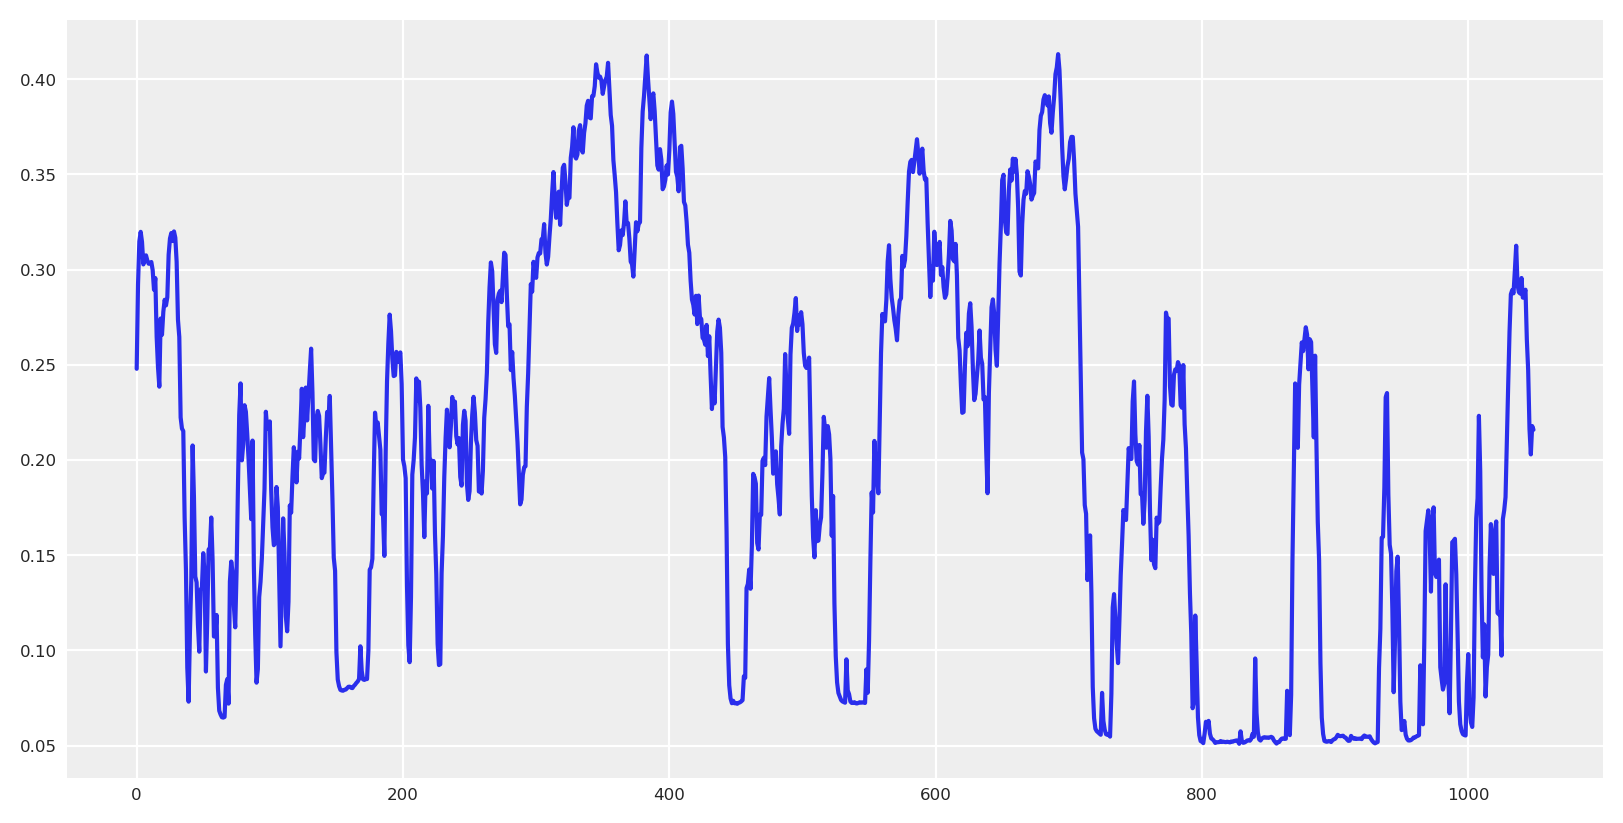

In [14]:
plt.plot(impressions_x4_ad_sat_eval)

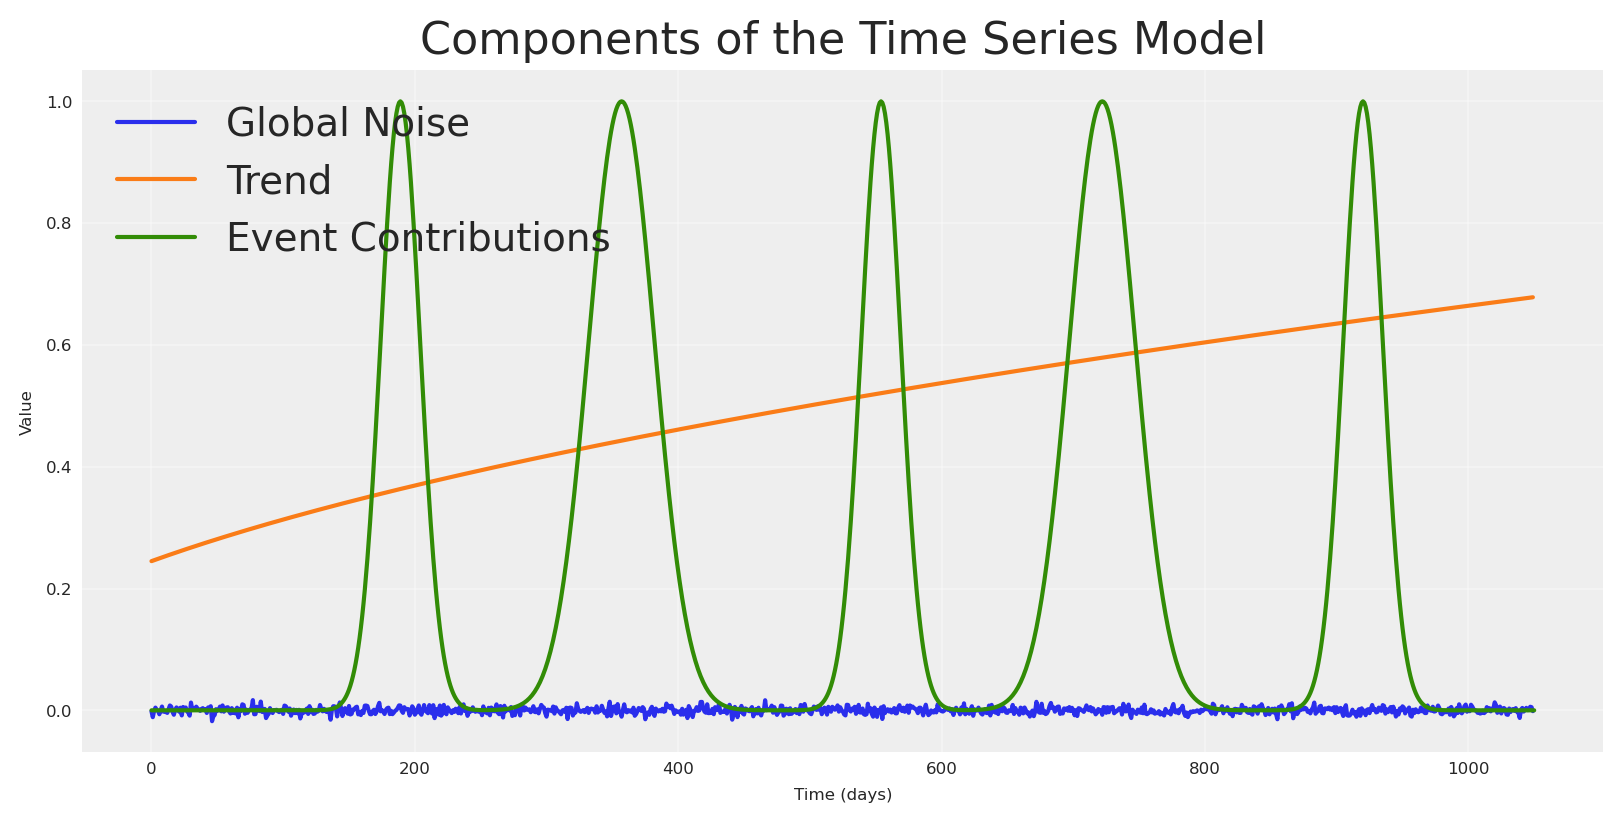

In [15]:
## Trend
trend = pt.vector("trend")
# Create a sample input for the trend
np_trend = (np.linspace(start=0.0, stop=0.40, num=n_observations) + 0.06) ** (0.1 / 0.2)

## NOISE
global_noise = pt.vector("global_noise")
# Create a sample input for the noise
pz_global_noise = pz.Normal(mu=0, sigma=0.005).rvs(
    size=n_observations, random_state=SEED
)

# EVENTS EFFECT
pt_event_signal = pt.vector("event_signal")
pt_event_contributions = pt.vector("event_contributions")

event_dates = ["24-12", "09-07"]  # List of events as month-day strings
std_devs = [25, 15]  # List of standard deviations for each event
events_coefficients = [0.080, 0.010]

signals_independent = []

# Initialize the event effect array
event_signal = np.zeros(len(date_range))
event_contributions = np.zeros(len(date_range))

# Generate event signals
for event, std_dev, event_coef in zip(
    event_dates, std_devs, events_coefficients, strict=False
):
    # Find all occurrences of the event in the date range
    event_occurrences = date_range[date_range.strftime("%d-%m") == event]

    for occurrence in event_occurrences:
        # Calculate the time difference in days
        time_diff = (date_range - occurrence).days

        # Generate the Gaussian basis for the event
        _event_signal = np.exp(-0.5 * (time_diff / std_dev) ** 2)

        # Add the event signal to the event effect
        signals_independent.append(_event_signal)
        event_signal += _event_signal

        event_contributions += _event_signal * event_coef

np_event_signal = event_signal
np_event_contributions = event_contributions

plt.plot(pz_global_noise, label="Global Noise")
plt.plot(np_trend, label="Trend")
plt.plot(np_event_signal, label="Event Contributions")
plt.title("Components of the Time Series Model")
plt.xlabel("Time (days)")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
target_var = rewrite_graph(
    impressions_x4_forward + pt_event_contributions + trend + global_noise
)

In [17]:
# Eval target_var and plot
target_var_eval = target_var.eval(
    {
        "impressions_x1": impressions_x1_var,
        "impressions_x2": impressions_x2_var,
        "impressions_x3": impressions_x3_var,
        "impressions_x4": impressions_x4_var,
        "beta_x1_x2": beta_x1_x2_var,
        "beta_x1_x3": beta_x1_x3_var,
        "beta_x2_x4": beta_x2_x4_var,
        "beta_x3_x4": beta_x3_x4_var,
        "x4_adstock_alpha": x4_adstock_alpha,
        "x4_sat_lam": x4_sat_lam,
        "x4_sat_alpha": x4_sat_alpha,
        "event_contributions": np_event_contributions[:-1],
        "trend": np_trend,
        "global_noise": pz_global_noise,
    }
)

In [113]:
# Scale target_var_eval to be between 0 and 1
min_val = np.min(target_var_eval)
max_val = np.max(target_var_eval)
scaled = (target_var_eval - min_val) / (max_val - min_val)
scaled

array([0.21681992, 0.26938662, 0.31933104, ..., 0.80417498, 0.82567496,
       0.81346198], shape=(1050,))

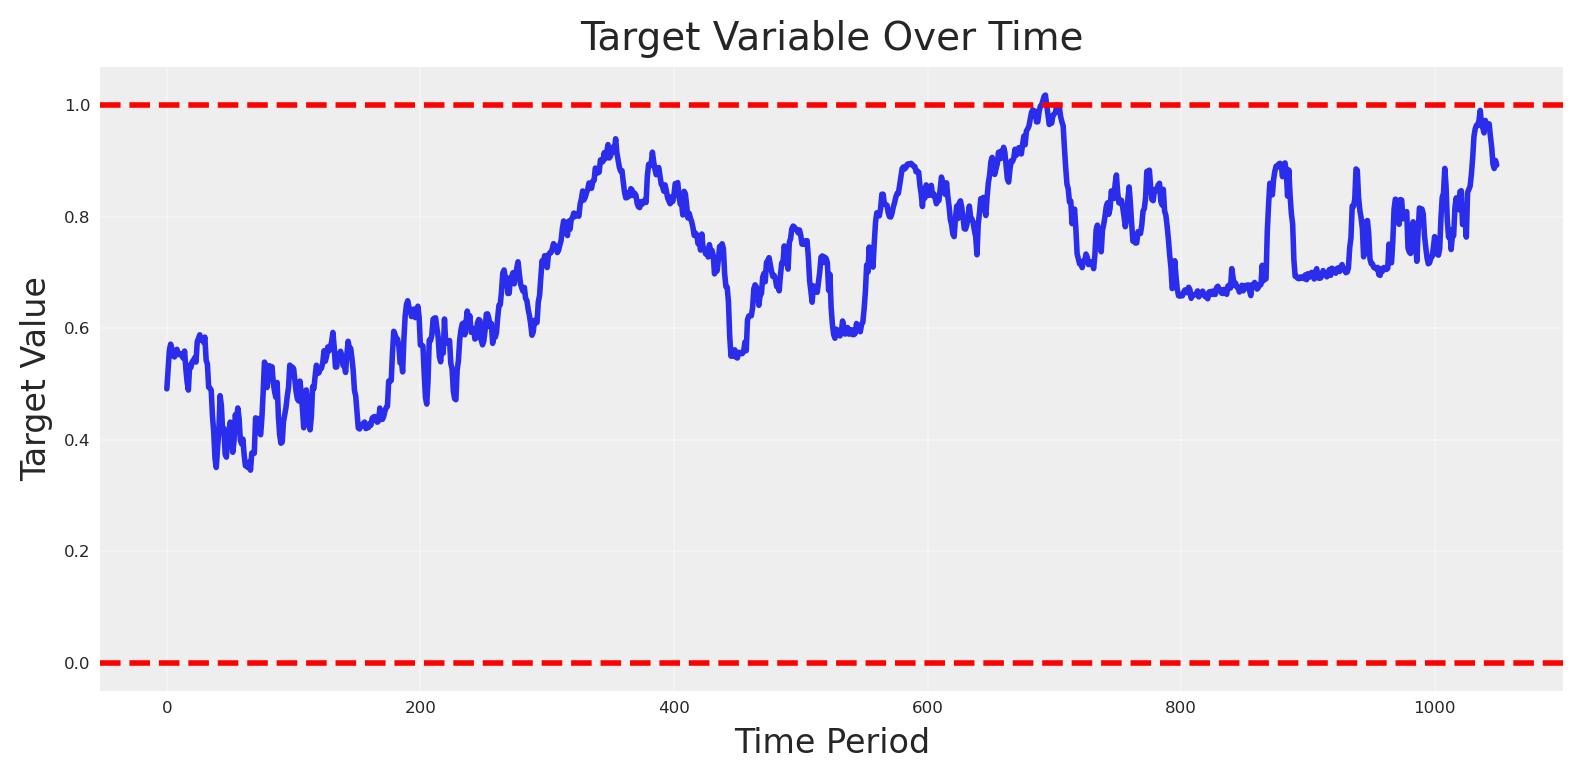

In [118]:
plt.plot(target_var_eval, linewidth=2)
plt.title("Target Variable Over Time", fontsize=14)
plt.xlabel("Time Period", fontsize=12)
plt.ylabel("Target Value", fontsize=12)
# horizontal line at y=1
plt.axhline(y=1, color="red", linestyle="--", linewidth=2)
plt.axhline(y=0, color="red", linestyle="--", linewidth=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

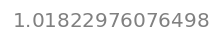

In [81]:
max(target_var_eval)

In [82]:
scaler_factor_for_target = 1
scaler_factor_for_impressions = 1
dates = pd.date_range(start="2020-01-01", periods=n_observations, freq="D")
data = pd.DataFrame(
    {
        "date": dates,
        "target_var": np.round(target_var_eval * scaler_factor_for_target, 4),
        "impressions_x1": np.round(
            impressions_x1_eval * scaler_factor_for_impressions, 4
        ),
        "impressions_x2": np.round(
            impressions_x2_eval * scaler_factor_for_impressions, 4
        ),
        "impressions_x3": np.round(
            impressions_x3_eval * scaler_factor_for_impressions, 4
        ),
        "impressions_x4": np.round(
            impressions_x4_eval * scaler_factor_for_impressions, 4
        ),
        "event_2020_09": np.round(signals_independent[0][:-1], 4),
        "event_2020_12": np.round(signals_independent[1][:-1], 4),
        "event_2021_09": np.round(signals_independent[2][:-1], 4),
        "event_2021_12": np.round(signals_independent[3][:-1], 4),
        "event_2022_09": np.round(signals_independent[4][:-1], 4),
    }
)
data["trend"] = data.index
data.head()

,date,target_var,impressions_x1,impressions_x2,impressions_x3,impressions_x4,event_2020_09,event_2020_12,event_2021_09,event_2021_12,event_2022_09,trend
0,2020-01-01,0.4913,0.1565,0.1147,0.2182,0.1097,0.0,0.0,0.0,0.0,0.0,0
1,2020-01-02,0.5267,0.1377,0.1133,0.2227,0.1104,0.0,0.0,0.0,0.0,0.0,1
2,2020-01-03,0.5603,0.1656,0.1138,0.2233,0.1205,0.0,0.0,0.0,0.0,0.0,2
3,2020-01-04,0.5715,0.1097,0.1127,0.2207,0.1192,0.0,0.0,0.0,0.0,0.0,3
4,2020-01-05,0.5635,0.0863,0.1137,0.2191,0.1127,0.0,0.0,0.0,0.0,0.0,4


In [83]:
# Building priors for adstock and saturation
adstock_priors = {
    "alpha": Prior("Beta", alpha=1, beta=1, dims="channel"),
}

adstock = GeometricAdstock(l_max=24, priors=adstock_priors)

saturation_priors = {
    "lam": Prior(
        "Gamma",
        mu=2,
        sigma=1,
        dims="channel",
    ),
    "alpha": Prior(
        "Gamma",
        mu=0.5,
        sigma=0.5,
        dims="channel",
    ),
}

saturation = MichaelisMentenSaturation(priors=saturation_priors)

# Split data into train and test sets
train_idx = 879

X_train = data.iloc[:train_idx].drop(columns=["target_var"])
X_test = data.iloc[train_idx:].drop(columns=["target_var"])
y_train = data.iloc[:train_idx]["target_var"]
y_test = data.iloc[train_idx:]["target_var"]

control_columns = [
    "event_2020_09",
    "event_2020_12",
    "event_2021_09",
    "event_2021_12",
    "event_2022_09",
    "trend",
]
channel_columns = [
    col for col in X_train.columns if col not in control_columns and col != "date"
]

# Model config
model_config = {
    "likelihood": Censored(
        Prior(
            "Normal",
            sigma=Prior("HalfNormal", sigma=1),
            dims="date",
        ),
        lower=0,
    )
}

# sampling options for PyMC
sample_kwargs = {
    "tune": 1000,
    "draws": 500,
    "chains": 4,
    "random_seed": SEED,
    "target_accept": 0.84,
}

non_causal_mmm = MMM(
    date_column="date",
    target_column="target_var",
    channel_columns=channel_columns,
    control_columns=control_columns,
    adstock=adstock,
    saturation=saturation,
    model_config=model_config,
    sampler_config=sample_kwargs,
)
non_causal_mmm.build_model(X_train, y_train)
non_causal_mmm.add_original_scale_contribution_variable(
    var=["channel_contribution", "y"]
)

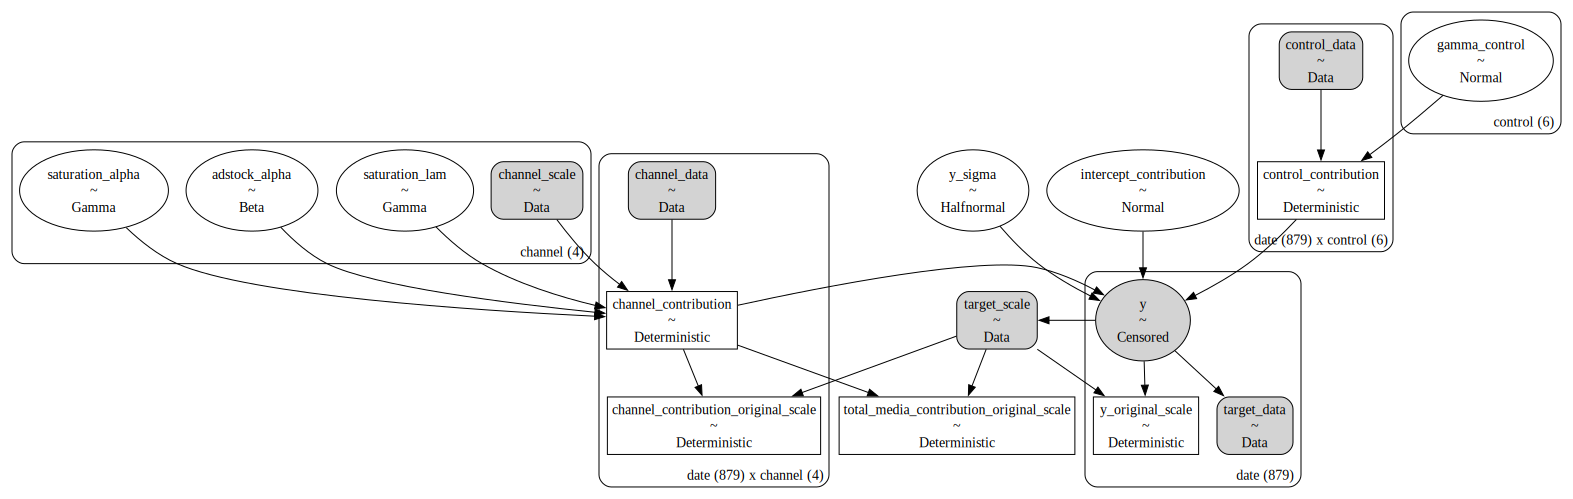

In [84]:
non_causal_mmm.model.to_graphviz()

In [121]:
non_causal_mmm.scalers._target.item(), non_causal_mmm.scalers._channel.values

(1.0182, array([0.7842, 0.1223, 0.3217, 0.206 ]))

In [85]:
non_causal_mmm.fit(
    X_train,
    y_train,
)
non_causal_mmm.sample_posterior_predictive(X_train, extend_idata=True, combined=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_alpha, saturation_lam, gamma_control, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 189 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Sampling: [y]


Output()

<xarray.Dataset> Size: 28MB
Dimensions:           (date: 879, sample: 2000)
Coordinates:
  * date              (date) datetime64[ns] 7kB 2020-01-01 ... 2022-05-28
  * sample            (sample) object 16kB MultiIndex
  * chain             (sample) int64 16kB 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * draw              (sample) int64 16kB 0 1 2 3 4 5 ... 495 496 497 498 499
Data variables:
    y                 (date, sample) float64 14MB 0.473 0.4667 ... 0.8877 0.8779
    y_original_scale  (date, sample) float64 14MB 0.4816 0.4752 ... 0.8939
Attributes:
    created_at:                 2025-09-28T21:13:14.654231+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1

In [102]:
X_test_x1_zero = X_test.copy()
X_test_x1_zero["impressions_x1"].iloc[:100] = 0

y_do_x1_zero = non_causal_mmm.sample_posterior_predictive(
    X_test_x1_zero,
    extend_idata=False,
    include_last_observations=True,
    random_seed=SEED,
    var_names=["channel_contribution_original_scale", "y_original_scale"],
)

y_do_x1 = non_causal_mmm.sample_posterior_predictive(
    X_test,
    extend_idata=False,
    include_last_observations=True,
    random_seed=SEED,
    var_names=["channel_contribution_original_scale", "y_original_scale"],
)

Sampling: [y]


Output()

Sampling: [y]


Output()

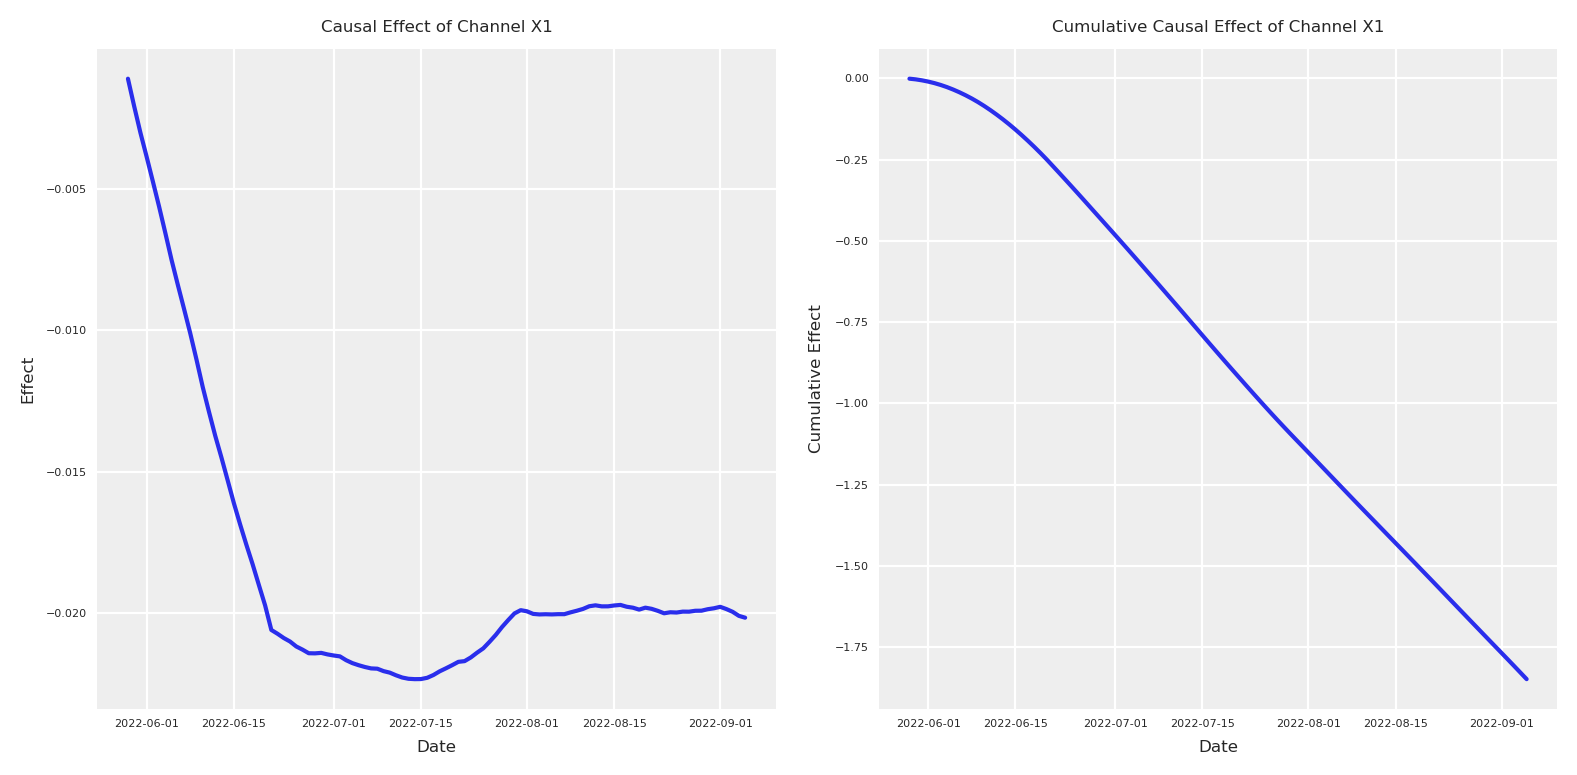

In [ ]:
# Calculate the causal effect as the difference between interventions
x1_causal_effect = (y_do_x1_zero - y_do_x1).channel_contribution_original_scale.sum(
    dim="channel"
)
# Get dates from the coordinates for x-axis
dates = x1_causal_effect.coords["date"].values[:100]  # Take only first 100 days

In [138]:
impressions_x1_var_intervention = impressions_x1_var.copy()
impressions_x1_var_intervention[880:980] = 0

impressions_x4_var_intervention = impressions_x4_var.copy()
impressions_x4_var_intervention[880:980] = 0

impressions_x2_var_intervention = impressions_x2_var.copy()
impressions_x2_var_intervention[880:980] = 0

impressions_x3_var_intervention = impressions_x3_var.copy()
impressions_x3_var_intervention[880:980] = 0

In [149]:
# Eval target_var and plot
target_var_x1_intervention_eval = impressions_x4_forward.eval(
    {
        "impressions_x1": impressions_x1_var_intervention,
        "impressions_x2": impressions_x2_var,
        "impressions_x3": impressions_x3_var,
        "impressions_x4": impressions_x4_var,
        "beta_x1_x2": beta_x1_x2_var,
        "beta_x1_x3": beta_x1_x3_var,
        "beta_x2_x4": beta_x2_x4_var,
        "beta_x3_x4": beta_x3_x4_var,
        "x4_adstock_alpha": x4_adstock_alpha,
        "x4_sat_lam": x4_sat_lam,
        "x4_sat_alpha": x4_sat_alpha,
    }
)

In [139]:
from pymc_marketing.mmm import NoAdstock, NoSaturation

In [143]:
X_train_x4 = data.iloc[:train_idx].drop(columns=["impressions_x4"])
X_test_x4 = data.iloc[train_idx:].drop(columns=["impressions_x4"])
y_train_x4 = data.iloc[:train_idx]["impressions_x4"]
y_test_x4 = data.iloc[train_idx:]["impressions_x4"]

In [165]:
mas_causal_mmm = MMM(
    date_column="date",
    target_column="impressions_x4",
    channel_columns=["impressions_x1"],
    # control_columns=control_columns,
    adstock=NoAdstock(l_max=24),
    saturation=NoSaturation(priors={"beta": Prior("Gamma", mu=1, sigma=1)}),
    model_config=model_config,
    sampler_config=sample_kwargs,
    time_varying_intercept=True,
)
mas_causal_mmm.build_model(
    X_train_x4,
    y_train_x4,
)
mas_causal_mmm.add_original_scale_contribution_variable(
    var=["channel_contribution", "y"]
)
mas_causal_mmm.fit(
    X_train_x4,
    y_train_x4,
)
mas_causal_mmm.sample_posterior_predictive(
    X_train_x4,
    extend_idata=True,
    combined=True,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_baseline, intercept_latent_process_raw_eta, intercept_latent_process_raw_ls, intercept_latent_process_raw_hsgp_coefs_offset, saturation_beta, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1716 seconds.
There were 1078 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Sampling: [y]


Output()

<xarray.Dataset> Size: 28MB
Dimensions:           (date: 879, sample: 2000)
Coordinates:
  * date              (date) datetime64[ns] 7kB 2020-01-01 ... 2022-05-28
  * sample            (sample) object 16kB MultiIndex
  * chain             (sample) int64 16kB 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * draw              (sample) int64 16kB 0 1 2 3 4 5 ... 495 496 497 498 499
Data variables:
    y                 (date, sample) float64 14MB 0.6261 0.5718 ... 0.4479
    y_original_scale  (date, sample) float64 14MB 0.129 0.1178 ... 0.09228
Attributes:
    created_at:                 2025-09-29T10:18:54.011586+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1

In [161]:
# X_test_x1_zero = X_test.copy()
# X_test_x1_zero["impressions_x1"].iloc[:100] = 0

y_do_x1_zero_mas = mas_causal_mmm.sample_posterior_predictive(
    X_test_x1_zero,
    extend_idata=False,
    include_last_observations=True,
    random_seed=SEED,
    var_names=["channel_contribution_original_scale", "y_original_scale"],
)

y_do_x1_mas = mas_causal_mmm.sample_posterior_predictive(
    X_test,
    extend_idata=False,
    include_last_observations=True,
    random_seed=SEED,
    var_names=["channel_contribution_original_scale", "y_original_scale"],
)

Sampling: [y]


Output()

Sampling: [y]


Output()

In [162]:
mas_causal_mmm.idata.posterior.saturation_beta.mean(dim=["chain", "draw"])

<xarray.DataArray 'saturation_beta' ()> Size: 8B
array(0.35518481)

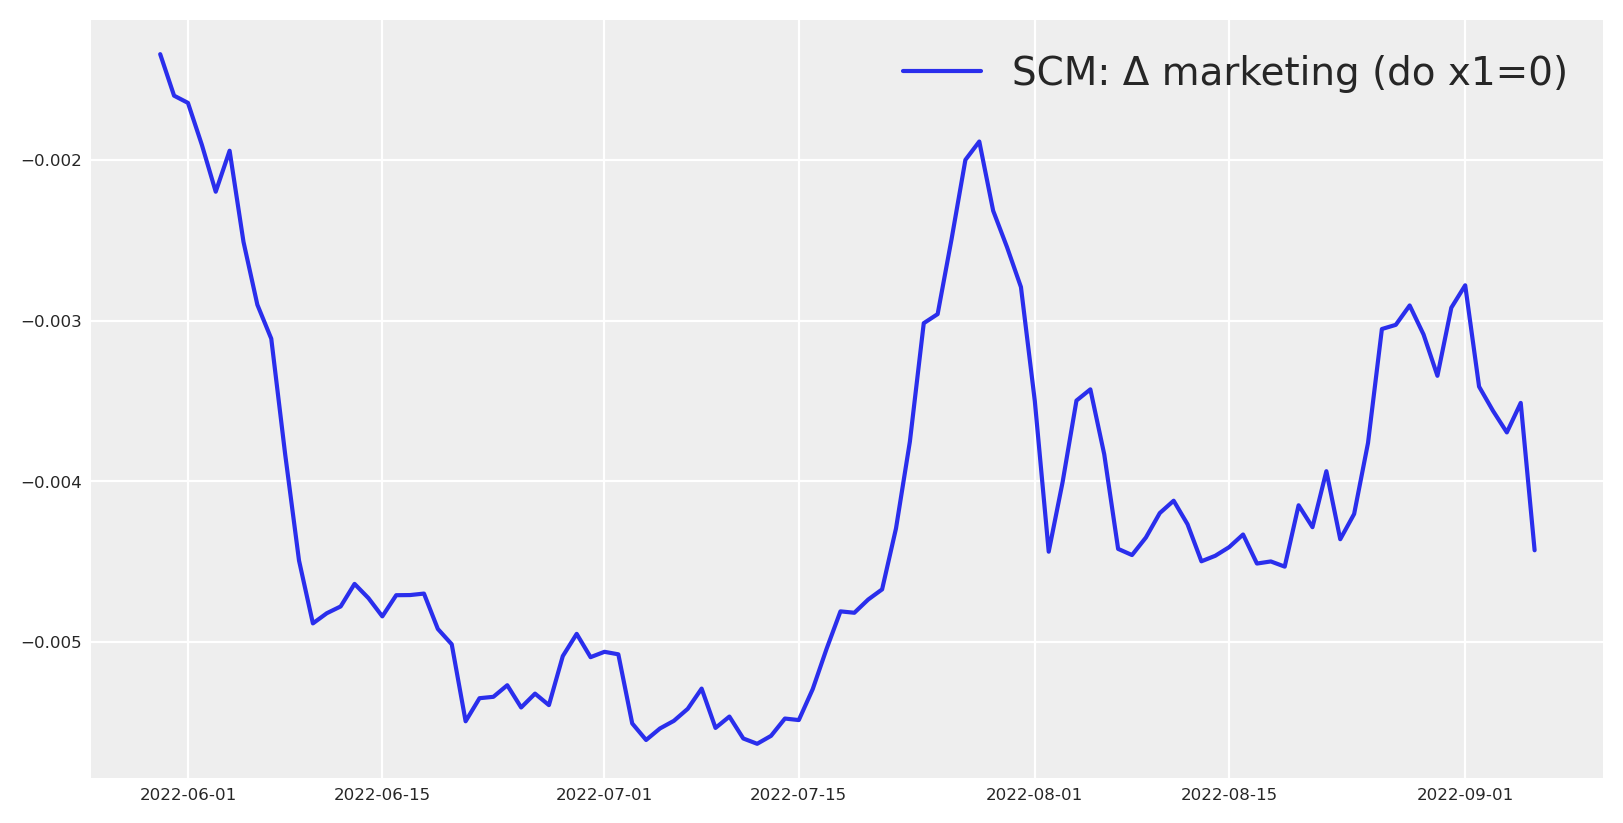

In [163]:
# Baseline (natural world)
x4_marketing_baseline = impressions_x4_forward.eval(
    {
        "impressions_x1": impressions_x1_var,
        "impressions_x2": impressions_x2_var,  # baseline RW
        "impressions_x3": impressions_x3_var,  # baseline RW
        "impressions_x4": impressions_x4_var,  # baseline RW
        "beta_x1_x2": beta_x1_x2_var,
        "beta_x1_x3": beta_x1_x3_var,
        "beta_x2_x4": beta_x2_x4_var,
        "beta_x3_x4": beta_x3_x4_var,
        "x4_adstock_alpha": x4_adstock_alpha,
        "x4_sat_lam": x4_sat_lam,
        "x4_sat_alpha": x4_sat_alpha,
    }
)

# Intervention world: do(x1=0) on [880:980)
x4_marketing_do = impressions_x4_forward.eval(
    {
        "impressions_x1": impressions_x1_var_intervention,  # only change!
        "impressions_x2": impressions_x2_var,
        "impressions_x3": impressions_x3_var,
        "impressions_x4": impressions_x4_var,
        "beta_x1_x2": beta_x1_x2_var,
        "beta_x1_x3": beta_x1_x3_var,
        "beta_x2_x4": beta_x2_x4_var,
        "beta_x3_x4": beta_x3_x4_var,
        "x4_adstock_alpha": x4_adstock_alpha,
        "x4_sat_lam": x4_sat_lam,
        "x4_sat_alpha": x4_sat_alpha,
    }
)

# Per-time marketing impact (true total effect via the SCM)
delta_marketing = x4_marketing_do - x4_marketing_baseline
win = slice(880, 980)
plt.plot(
    pd.date_range(start="2020-01-01", periods=n_observations, freq="D")[win],
    delta_marketing[win],
    label="SCM: Δ marketing (do x1=0)",
)
plt.legend()

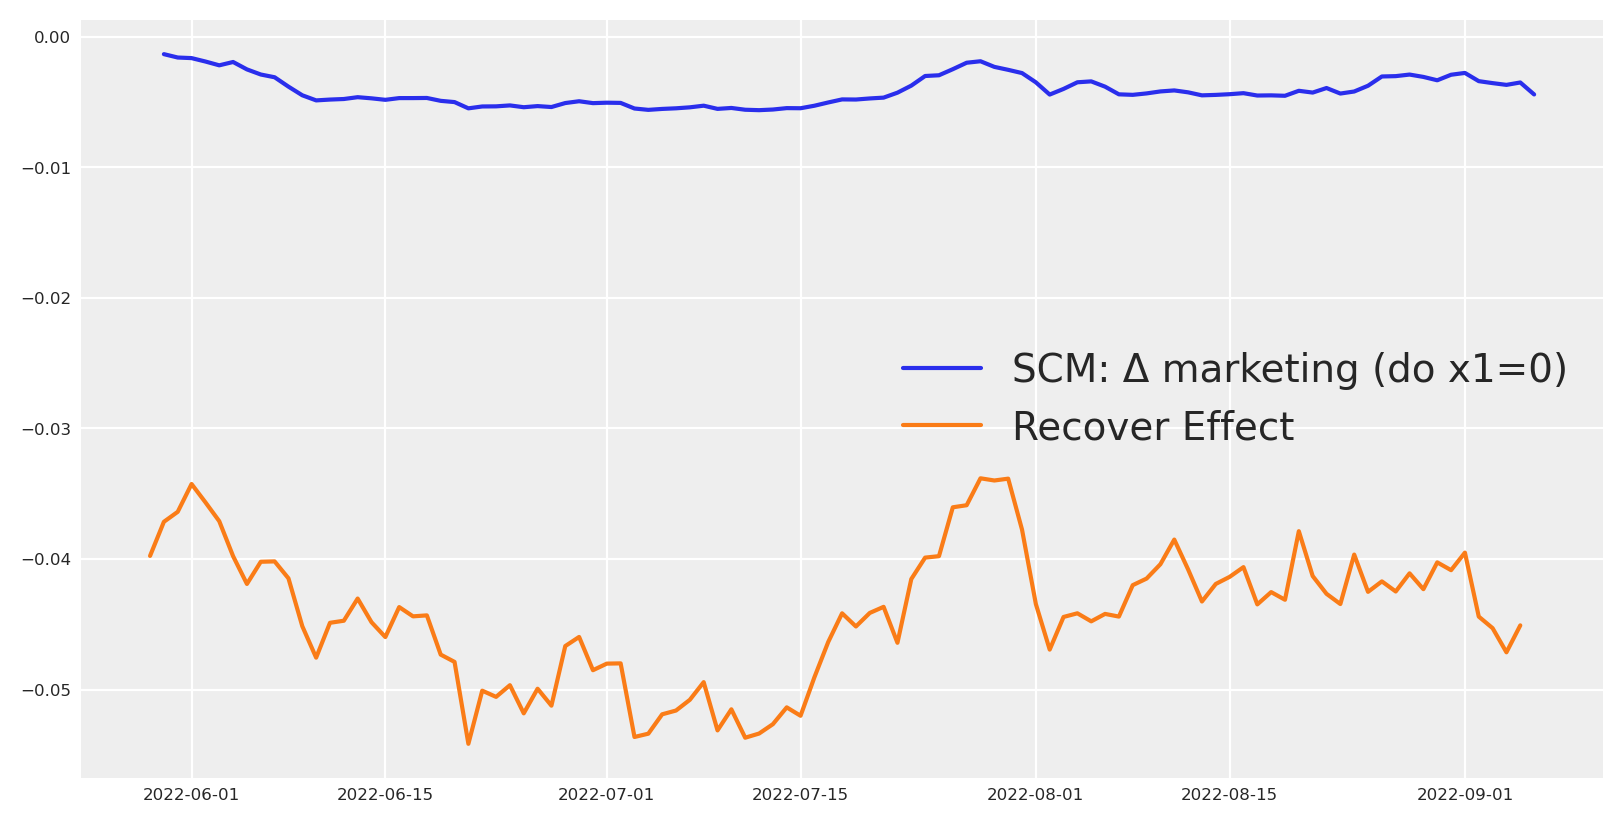

In [164]:
# Calculate the causal effect as the difference between interventions
x1_causal_effect_mas = (
    y_do_x1_zero_mas - y_do_x1_mas
).channel_contribution_original_scale.sum(dim="channel")
# Get dates from the coordinates for x-axis
dates = x1_causal_effect_mas.coords["date"].values[:100]  # Take only first 100 days

plt.plot(
    pd.date_range(start="2020-01-01", periods=n_observations, freq="D")[win],
    delta_marketing[win],
    label="SCM: Δ marketing (do x1=0)",
)
# Calculate mean and quantiles
mean_effect = x1_causal_effect_mas.mean(dim="sample")[:100]
plt.plot(dates, mean_effect, label="Recover Effect")
plt.legend()